In [1]:
from glob import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon


In [2]:
# all_files = glob("/nas/houce/Alphaearth_embedding/GEE_extracted/*/*/*.tif")
download_records = glob("/nas/houce/Alphaearth_embedding/GEE_extracted/*/metadata/tem.csv")
for i, file_path in enumerate(download_records):
    if i == 0:
        download_file_df = pd.read_csv(file_path)
    else:
        temp_df = pd.read_csv(file_path)
        download_file_df = pd.concat([download_file_df, temp_df], axis=0, ignore_index=True)

download_file_df['geometry'] = download_file_df.apply(
    lambda row: Polygon([
        (row['lon_min'], row['lat_min']),
        (row['lon_min'], row['lat_max']),
        (row['lon_max'], row['lat_max']),
        (row['lon_max'], row['lat_min']),
        (row['lon_min'], row['lat_min'])
    ]), axis=1
)

download_gdf = gpd.GeoDataFrame(download_file_df, geometry='geometry', crs="EPSG:4326")
total_boundary = [download_file_df['lon_min'].min(), download_file_df['lat_min'].min(),
                  download_file_df['lon_max'].max(), download_file_df['lat_max'].max()]


In [3]:
world = gpd.read_file("/nas/houce/country_boundary/ne_110m_admin_0_countries.geojson")

In [4]:
all_data = pd.read_csv('human_settlement_grid_cells.csv')
all_data_merged = all_data.merge(download_gdf[['geometry', 'lon_min','lon_max','lat_min','lat_max']], on=['lon_min','lon_max','lat_min','lat_max'], how='left', indicator=True)
all_africa_data = all_data_merged[(all_data_merged['_merge'] == 'left_only') &
 (all_data_merged['lon_min'] >= total_boundary[0]) &
 (all_data_merged['lon_max'] <= total_boundary[2]) &
 (all_data_merged['lat_min'] >= total_boundary[1]) &
 (all_data_merged['lat_max'] <= total_boundary[3])]

all_africa_data.to_csv('human_settlement_grid_cells_africa_left.csv', index=False)

In [5]:
# download_gdf.to_csv("/nas/houce/Alphaearth_embedding/metadata/downloaded_grid_cells.csv", index=False)

In [6]:
# [west, south, east, north]


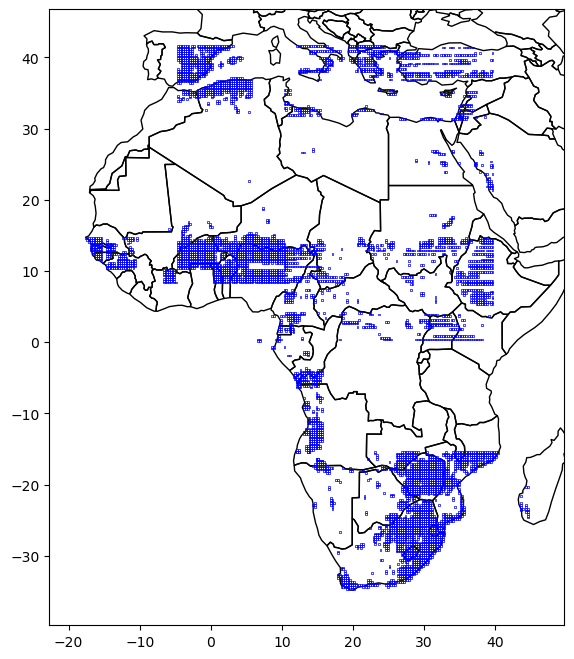

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
world.boundary.plot(ax=ax, color='black', linewidth=1)
download_gdf.boundary.plot(ax=ax, color='blue', linewidth=0.5)

ax.set_xlim(total_boundary[0]-5, total_boundary[2]+5)
ax.set_ylim(total_boundary[1]-5, total_boundary[3]+5)
plt.show()